<a href="https://colab.research.google.com/github/SRBSaurabh/Stock_Price_Forecasting/blob/main/Stock_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from math import sqrt
from sklearn.metrics import mean_squared_error
# Import real-time Stock Market API
!pip install yfinance
import yfinance as yf

# ### Technical Analysis Library for Python:
!pip install talib-binary
import talib

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 15.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 2.4 MB 7.9 MB/s 


# Loading the Stock Price Data-Set of "Hindustan Unilever Limited" from year Jan-2000 till  current year Dec-2021.

## Source1: **Official site of National Stock Exchange of India**
*link:  https://www.nseindia.com/get-quotes/equity?symbol=HINDUNILVR*
#### Source2: **Yahoo Finance Stock Data-API**

In [2]:
# data_ = pd.read_csv("Quote-Equity-HINDUNILVR-EQ-01-01-2000-to-31-12-2021.csv")

##============ Company's Name Ticker ============##
symbol = 'HINDUNILVR.NS'

ticker = yf.Ticker(symbol)
data = ticker.history(period='max', interval='1d', rounding=True, prepost=True, actions=False)
df = pd.DataFrame(data)[['Close','Volume']]
last_5days=list(df.tail(10).index)
last_5days=[str(i)[:10] for i in last_5days]

## Features Needed
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
df["52W_H"] = df['Close'].rolling(window =200).max()
df["52W_L"] = df['Close'].rolling(window =200).min()
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
df = pd.DataFrame(df)
df

,Close,Volume,SMA_20,SMA_50,52W_H,52W_L,RSI_14
Date,,,,,,,
1996-01-01,36.10,11000,NaN,NaN,NaN,NaN,NaN
1996-01-02,36.48,203500,NaN,NaN,NaN,NaN,NaN
1996-01-03,36.27,58000,NaN,NaN,NaN,NaN,NaN
1996-01-04,36.27,111500,NaN,NaN,NaN,NaN,NaN
1996-01-05,36.21,39500,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-02-01,2305.65,1270508,2352.6325,2334.614,2795.27,2230.25,46.082007
2022-02-02,2327.90,1246111,2348.9650,2333.288,2795.27,2230.25,49.334532
2022-02-03,2298.15,1448039,2343.0825,2331.756,2795.27,2230.25,45.391728


## **Problem Statement**:- <br>
### *Predicting the Share Price of a Company(eg. HUL) for the Next 2 Successive years Jan-2020 till Dec-2021, by just Providing the Historical Data of the Past years from Jan-2000 till Dec-2019.*

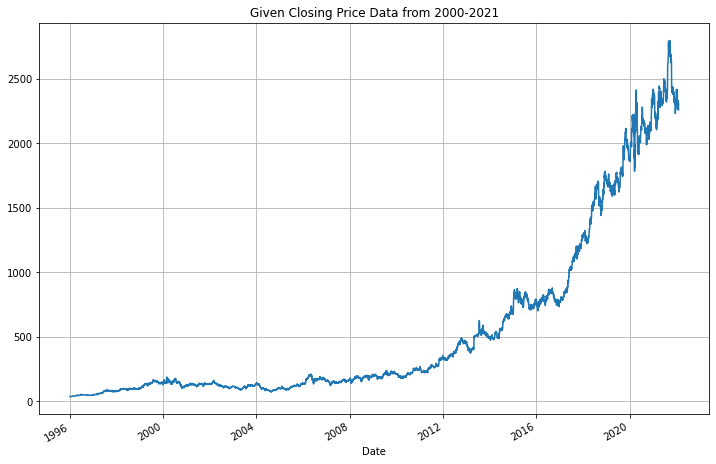

In [3]:
# Visualizing the Given Closing Price Data
df['Close'].plot(figsize=(12,8), title='Given Closing Price Data from 2000-2021')
plt.grid()
plt.show()

In [4]:
##============  Data Preparation for training  ============##
df0=df.copy()
df0['Price_Before_9Days']= df0['Close'].shift(+9)
df0['Price_Before_20Days']= df0['Close'].shift(+20)
df0['Price_Before_50Days']= df0['Close'].shift(+50)
df0['Price_Before_200Days']= df0['Close'].shift(+200)

df0 = df0.dropna()
df0.tail()

,Close,Volume,SMA_20,SMA_50,52W_H,52W_L,RSI_14,Price_Before_9Days,Price_Before_20Days,Price_Before_50Days,Price_Before_200Days
Date,,,,,,,,,,,
2022-02-01,2305.65,1270508,2352.6325,2334.614,2795.27,2230.25,46.082007,2369.5,2361.30,2388.55,2421.89
2022-02-02,2327.90,1246111,2348.9650,2333.288,2795.27,2230.25,49.334532,2309.9,2401.25,2394.20,2428.05
2022-02-03,2298.15,1448039,2343.0825,2331.756,2795.27,2230.25,45.391728,2261.8,2415.80,2374.75,2426.33
2022-02-04,2306.60,1014561,2338.8425,2330.907,2795.27,2230.25,46.694828,2325.4,2391.40,2349.05,2404.37
2022-02-07,2257.60,1207247,2330.9150,2329.357,2795.27,2230.25,40.638842,2284.6,2416.15,2335.10,2365.69


In [5]:
# Train Test Test Split
train_start = dt.date(2000,1,1)
train_end = dt.date(2019,12,31)
train_data = df0.loc[train_start:train_end]

test_start = dt.date(2020,1,1)
test_end = dt.date(2021,12,31)
test_data = df0.loc[test_start:test_end]
X_train,y_train=train_data.iloc[:, 1:],train_data['Close']
X_test,y_test=test_data.iloc[:, 1:],test_data['Close']

print(train_data.shape, test_data.shape)

(5001, 11) (499, 11)


## Data Pre-processing for Regression Models

In [6]:
##============  Feature Scalling  ============##
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
# To Avoid the Data Leakage & Overfitting
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

print('Preprocessing Done...!')

Preprocessing Done...!


# Building & Training the Following ML models:
##  1) Linear Regression model <br>
##  2) Random Forest Regressor from Ensemble models <br>
##  3) Support Vector Regressor

In [7]:
##============  Importing & Defining ML Models ============##
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(n_estimators=100, random_state=42, max_samples=800)

from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', degree=3, C=1000)

##============  Training ML models  ============##
linear_model.fit(X_train, y_train)
forest_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)

print('Model Training Completed...!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Model Training Completed...!


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 4)  Building & Training a RNN model, called "Long Short Term Memory model":
## LSTM Neural Network...

In [8]:
df1=df.copy()   #Making Another Copy of given dataset
df1=df1['Close']
index=df1.index
df1

Date
1996-01-01      36.10
1996-01-02      36.48
1996-01-03      36.27
1996-01-04      36.27
1996-01-05      36.21
               ...   
2022-02-01    2305.65
2022-02-02    2327.90
2022-02-03    2298.15
2022-02-04    2306.60
2022-02-07    2257.60
Name: Close, Length: 6570, dtype: float64

### Data Preparation & Data Pre-processing for LSTM Neural Network

In [9]:
## Feature Scalling
from sklearn.preprocessing import MinMaxScaler
scaler_=MinMaxScaler(feature_range=(0,1))
df1=scaler_.fit_transform(np.array(df1).reshape(-1,1))
df1=pd.DataFrame(df1, index=index)
## Splitting dataset into train and test split
train_data = df1.loc[train_start:train_end]
test_data = df1.loc[test_start:test_end]
print(train_data.shape, test_data.shape)

(5001, 1) (499, 1)


In [10]:
def timeSeries_trainTest_split(dataset, rolling_time_window=10):
  dataX, dataY = [], []
  for i in range(len(dataset)-rolling_time_window-1):
    # Pointing on a slice, like a Sliding window problem
    sliced = dataset[i:(i+rolling_time_window), 0]
    dataX.append(sliced)
    dataY.append(dataset[(i+rolling_time_window), 0])
  return np.array(dataX), np.array(dataY)

# Additional Train-Test Split required for the Time Series Data
rolling_time_window = 50   ##=====>>>> with how much Rolling time do you want your model to Learn...!!!

X_train_, y_train_ = timeSeries_trainTest_split(train_data.values, rolling_time_window)
X_test_, y_test_ = timeSeries_trainTest_split(test_data.values, rolling_time_window)

# reshape 2D data into 3D shape like (samples, time rolling window, time window prediction) which is required for LSTM
X_train_ = X_train_.reshape(X_train_.shape[0],X_train_.shape[1] , 1)
X_test_ = X_test_.reshape(X_test_.shape[0],X_test_.shape[1] , 1)

print(X_train_.shape)
print('Preprocessing Done...!')

(4950, 50, 1)
Preprocessing Done...!


#Making Other Model- Multivariet RNN

In [11]:
# Importing dependencies

import os
# Import real-time Stock Market API
!pip install yfinance
import yfinance as yf
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time

In [12]:
# symbol = 'HINDUNILVR.NS'

# ticker = yf.Ticker(symbol)
# data = ticker.history(start='2000-01-01', end='2022-01-01', interval='1d', rounding=True, prepost=True, actions=False)
df = pd.DataFrame(data)
df

,Open,High,Low,Close,Volume
Date,,,,,
1996-01-01,36.33,36.55,36.10,36.10,11000
1996-01-02,36.10,36.62,36.11,36.48,203500
1996-01-03,36.48,36.42,36.10,36.27,58000
1996-01-04,36.21,36.39,36.15,36.27,111500
1996-01-05,36.27,36.45,35.92,36.21,39500
...,...,...,...,...,...
2022-02-01,2303.30,2320.00,2278.40,2305.65,1270508
2022-02-02,2324.10,2333.00,2296.55,2327.90,1246111
2022-02-03,2329.00,2331.95,2290.00,2298.15,1448039


In [13]:
df.corr()['Close']

Open      0.999823
High      0.999924
Low       0.999917
Close     1.000000
Volume    0.015615
Name: Close, dtype: float64

In [14]:
# print(df.describe().Volume) 
# df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with Volume value 0, i.e. NO Trading Happened on that day
# df['Volume'].hist(bins = 2)

In [15]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
callbacks_list

In [16]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],
                        input_shape = (X_train.shape[1],X_train.shape[2]),
                        return_sequences = True,
                        activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],
                            activation = 'relu',
                            return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))

    # model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(tf.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,
                        validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [17]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [18]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [19]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

#Model Building

In [20]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(6570, 3)
              Close     High   Volume
Date                                 
2022-02-01  2305.65  2320.00  1270508
2022-02-02  2327.90  2333.00  1246111
2022-02-03  2298.15  2331.95  1448039
2022-02-04  2306.60  2312.75  1014561
2022-02-07  2257.60  2316.70  1207247


In [21]:
# Train Val Test Split
train_start = dt.date(2000,1,1)
train_end = dt.date(2017,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2018,1,1)
val_end = dt.date(2019,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020,1,1)
test_end = dt.date(2021,12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(4512, 3) (489, 3) (499, 3)


In [22]:
train_data

,Close,High,Volume
Date,,,
2000-01-03,137.80,137.80,249030
2000-01-04,136.22,142.19,585140
2000-01-05,131.37,134.36,802960
2000-01-06,136.64,140.93,1900320
2000-01-07,144.09,146.43,1925820
...,...,...,...
2017-12-22,1282.05,1284.88,561400
2017-12-26,1274.11,1279.59,913529
2017-12-27,1278.22,1289.13,569851


In [23]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(4512, 3) (489, 3) (499, 3)


In [24]:
timesteps = 50      #Rolling Time Window
hl = [45,50]        #Neurons
lr = 1e-3           #Learning Rate
batch_size = 60     #Learning in the Batch of
num_epochs = 100    #Revising the Learnings

Epoch 1/100
75/75 [==============================] - 6s 41ms/step - loss: 0.0021 - val_loss: 0.0145
Epoch 2/100
75/75 [==============================] - 4s 59ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 3/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 4/100
75/75 [==============================] - 4s 59ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 5/100
75/75 [==============================] - 5s 66ms/step - loss: 0.0099 - val_loss: 0.0388
Epoch 6/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0255 - val_loss: 0.0077
Epoch 7/100
75/75 [==============================] - 4s 56ms/step - loss: 0.0089 - val_loss: 0.0079
Epoch 8/100
75/75 [==============================] - 5s 61ms/step - loss: 0.0042 - val_loss: 0.0123
Epoch 9/100
75/75 [==============================] - 5s 66ms/step - loss: 0.0024 - val_loss: 0.0116
Epoch 10/100
75/75 [==============================] - 5s 61ms/step - loss: 0.0014 - val_loss: 0.0023

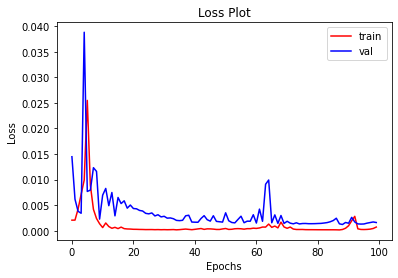

In [25]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.009312822520837772
RMSE = 0.09650296638361834
R-Squared Score = 0.6421211314630293


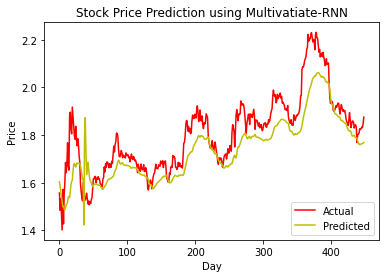

In [26]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,50)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [27]:
Tr = np.broadcast_to(true.reshape(-1,1), (true.shape[0], 3))
True_ = pd.DataFrame(sc.inverse_transform(Tr)).iloc[:, 0]
Pr = np.broadcast_to(predicted.reshape(-1,1), (predicted.shape[0], 3))
Predic_ = pd.DataFrame(sc.inverse_transform(Pr)).iloc[:, 0]

True_, Predic_

(0      1971.42
 1      1882.89
 2      1943.16
 3      1865.34
 4      1782.44
         ...   
 444    2301.40
 445    2309.10
 446    2306.85
 447    2325.60
 448    2360.15
 Name: 0, Length: 449, dtype: float64, 0      2028.472656
 1      2007.914429
 2      1976.720215
 3      1953.058472
 4      1924.560669
           ...     
 444    2222.239258
 445    2223.562012
 446    2225.341553
 447    2226.515625
 448    2230.103027
 Name: 0, Length: 449, dtype: float32)

### Build & Train LSTM model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### Create the Stacked LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=X_train_.shape[1:]))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Model Training...
lstm_model.fit(X_train_, y_train_,epochs=80,batch_size=60,verbose=1)
lstm_model.summary()

Epoch 1/80
83/83 [==============================] - 8s 57ms/step - loss: 0.0026
Epoch 2/80
83/83 [==============================] - 5s 56ms/step - loss: 7.0142e-05
Epoch 3/80
83/83 [==============================] - 5s 57ms/step - loss: 7.5597e-05
Epoch 4/80
83/83 [==============================] - 5s 56ms/step - loss: 6.6267e-05
Epoch 5/80
83/83 [==============================] - 5s 56ms/step - loss: 6.0159e-05
Epoch 6/80
83/83 [==============================] - 5s 56ms/step - loss: 5.6129e-05
Epoch 7/80
83/83 [==============================] - 5s 56ms/step - loss: 5.6934e-05
Epoch 8/80
83/83 [==============================] - 5s 56ms/step - loss: 6.5063e-05
Epoch 9/80
83/83 [==============================] - 5s 58ms/step - loss: 5.7085e-05
Epoch 10/80
83/83 [==============================] - 5s 56ms/step - loss: 4.9720e-05
Epoch 11/80
83/83 [==============================] - 5s 56ms/step - loss: 6.1521e-05
Epoch 12/80
83/83 [==============================] - 5s 57ms/step - loss: 4.76

In [29]:
# ##============ HYPER-Tuning the Model ============##

# from sklearn.metrics import mean_squared_error
# from math import sqrt

# for i in range(20, 130, 20):
#   lstm_model.fit(X_train_, y_train_,epochs=8,batch_size=i,verbose=0)
#   lstm_Pred = lstm_model.predict(X_test_)
#   rmse_lstm = sqrt(mean_squared_error(lstm_Pred, y_test_))
#   print(i, round(1-rmse_lstm, 4)*100)

# Making Predictions & Checking their Accuracies

In [30]:
##============  Making Predictions  ============##
linear_Pred = linear_model.predict(X_test)
forest_Pred = forest_model.predict(X_test)
svr_Pred = svr_model.predict(X_test)
lstm_Pred = lstm_model.predict(X_test_)

##============  Checking Erros on Testing Data  ============##
rmse_linear = sqrt(mean_squared_error(linear_Pred, y_test))
rmse_forest = sqrt(mean_squared_error(forest_Pred, y_test))
rmse_svr = sqrt(mean_squared_error(svr_Pred, y_test))
rmse_lstm = sqrt(mean_squared_error(lstm_Pred, y_test_))

print("\n======>>> 'Root Mean Squared Error' for Testing Data======>>>")
print("RMSE for SVR Model is------------------------>", round(rmse_svr,3))
print("RMSE for Random Forest Regression Model is--->", round(rmse_forest,3))
print("RMSE for Linear Regression Model is---------->", round(rmse_linear,3))
print("RMSE for LSTM Model is----------------------->", round(rmse_lstm,3))
print("RMSE for Multi-RNN Model is------------------>", round(rmse,3))

##============  Calculation Accuracy of the Model ============##
print("\n======>>> 'Training Data Prediction Accuracy'  ======>>>")
print("Accuracy for SVR Model is------------------------>", round(1-sqrt(mean_squared_error(svr_model.predict(X_train), y_train)), 4)*100)
print("Accuracy for Random Forest Regression Model is--->", round(1-sqrt(mean_squared_error(forest_model.predict(X_train), y_train)), 4)*100)
print("Accuracy for Linear Regression Model is---------->", round(1-sqrt(mean_squared_error(linear_model.predict(X_train), y_train)), 4)*100)
print("Accuracy for LSTM Model is----------------------->", round(1-sqrt(mean_squared_error(lstm_model.predict(X_train_), y_train_)), 4)*100)
print("\n========>>> 'Testing Data Prediction Accuracy'======>>>")
print("Accuracy for SVR Model is------------------------>", round(1-rmse_svr, 4)*100)
print("Accuracy for Random Forest Regression Model is--->", round(1-rmse_forest, 4)*100)
print("Accuracy for Linear Regression Model is---------->", round(1-rmse_linear, 4)*100)
print("Accuracy for LSTM Model is----------------------->", round(1-rmse_lstm, 4)*100)

###============  Inverse Scaling for the Forecasted value  ============###
lstm_Pred=scaler_.inverse_transform(lstm_Pred.reshape(-1, 1))
linear_Pred=scaler.inverse_transform(linear_Pred.reshape(1, -1)).T
forest_Pred=scaler.inverse_transform(forest_Pred.reshape(1, -1)).T
svr_Pred=scaler.inverse_transform(svr_Pred.reshape(1, -1)).T
original_Price=scaler.inverse_transform(y_test)


======>>> 'Root Mean Squared Error' for Testing Data======>>>
RMSE for SVR Model is------------------------> 0.412
RMSE for Random Forest Regression Model is---> 0.16
RMSE for Linear Regression Model is----------> 0.034
RMSE for LSTM Model is-----------------------> 0.017
RMSE for Multi-RNN Model is------------------> 0.097

======>>> 'Training Data Prediction Accuracy'  ======>>>
Accuracy for SVR Model is------------------------> 95.88
Accuracy for Random Forest Regression Model is---> 99.57000000000001
Accuracy for Linear Regression Model is----------> 99.35000000000001
Accuracy for LSTM Model is-----------------------> 99.61

========>>> 'Testing Data Prediction Accuracy'======>>>
Accuracy for SVR Model is------------------------> 58.84
Accuracy for Random Forest Regression Model is---> 84.03
Accuracy for Linear Regression Model is----------> 96.64
Accuracy for LSTM Model is-----------------------> 98.29


# Plotting "Actual Price  v/s  Predicted Prices" given by all the Models

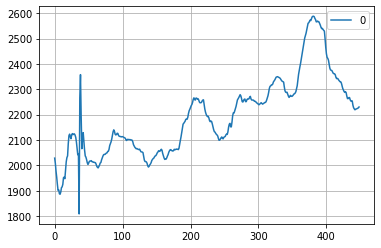

In [31]:
pd.DataFrame(Predic_).plot(grid=True)

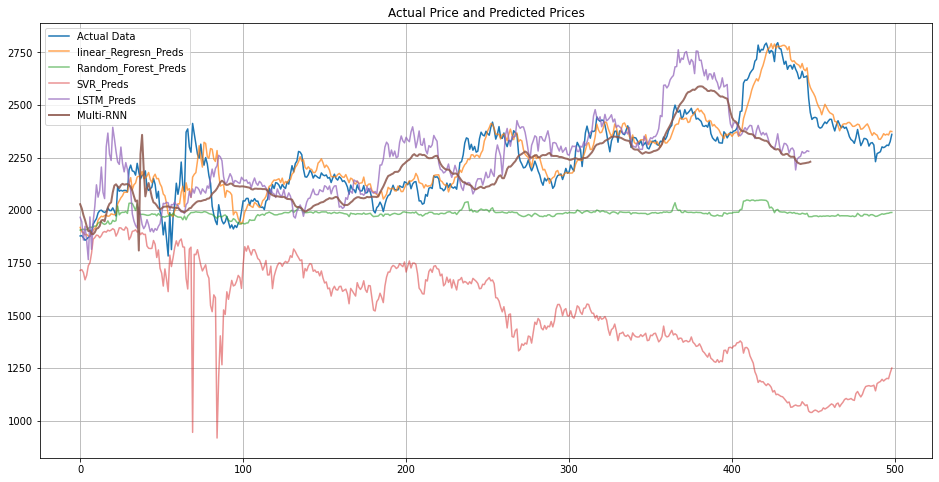

In [32]:
plt.figure(figsize=(16,8))
plt.title('Actual Price and Predicted Prices')
plt.plot(original_Price, alpha=1, label='Actual Data')

plt.plot(linear_Pred, alpha=0.7, label='linear_Regresn_Preds')
plt.plot(forest_Pred, alpha=0.6, label='Random_Forest_Preds')
plt.plot(svr_Pred, alpha=0.5, label='SVR_Preds')
plt.plot(lstm_Pred, alpha=0.75, label='LSTM_Preds')
plt.plot(Predic_, alpha=0.85, label='Multi-RNN',linewidth=2)
plt.legend()
plt.grid()
plt.show()

## Just to get some Glimps of the Predicated & Actual Prices: <br>
###Here I'm Showing the Last 10 Days Predicted Stock Prices in INR(₹)

In [33]:
pd.DataFrame(np.concatenate((svr_Pred[-10:],forest_Pred[-10:],linear_Pred[-10:],lstm_Pred[-10:],Predic_.values[-10:].reshape(-1,1),original_Price[-10:].reshape(-1,1)), axis=1), 
             columns=['SVR Predict', 'Random_Forest Predict', 'Linear_Regr Predict', 'LSTM Predict', 'multi-RNN', 'Real Price'], index=last_5days)

,SVR Predict,Random_Forest Predict,Linear_Regr Predict,LSTM Predict,multi-RNN,Real Price
2022-01-24,1176.929051,1971.6079,2356.202557,2281.881104,2237.315674,2269.10
2022-01-25,1182.625969,1975.1095,2337.708520,2191.163086,2227.294678,2272.85
2022-01-27,1186.649593,1978.9911,2336.253866,2243.110352,2222.732422,2277.65
2022-01-28,1197.160564,1982.7635,2348.065045,2251.176514,2219.114502,2300.65
2022-01-31,1189.041027,1980.8283,2363.226038,2255.740723,2221.251221,2296.95
2022-02-01,1196.073725,1983.0901,2356.656435,2278.662598,2222.239258,2301.40
2022-02-02,1201.809511,1984.8792,2361.028369,2270.882568,2223.562012,2309.10
2022-02-03,1199.890030,1985.6225,2357.086909,2273.981689,2225.341553,2306.85
2022-02-04,1226.967684,1988.6472,2375.116815,2282.332764,2226.515625,2325.60
2022-02-07,1250.616453,1989.2747,2373.553889,2279.611084,2230.103027,2360.15


# **Observations**:

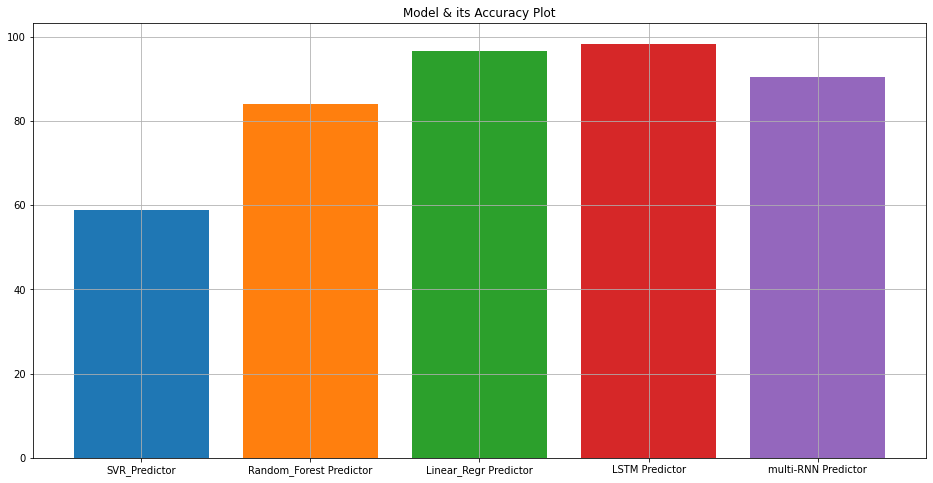

In [34]:
plt.figure(figsize=(16,8))
plt.title('Model & its Accuracy Plot')
plt.bar('SVR_Predictor', round(1-rmse_svr, 4)*100)
plt.bar('Random_Forest Predictor', round(1-rmse_forest, 4)*100)
plt.bar('Linear_Regr Predictor', round(1-rmse_linear, 4)*100)
plt.bar('LSTM Predictor', round(1-rmse_lstm, 4)*100)
plt.bar('multi-RNN Predictor', round(1-rmse, 4)*100)

plt.grid()
plt.show()

# **Conclusions**:

After Thoroughly working with all the 4 models, which are coming from totally Different modeling techiniques we can say that,

**1)** 
*Gradient Descent Algorithm Based Linear Regression model works Prety well for such a Time-Series Predictions.* <br><br>
**2)**
Whereas Recurrent Neural Network Based LSTM, Performed exceptionally well for the given dataset. <br>

> Also, During LSTM Hyper-Tuning...I've also Noticed that, 
*when number of Epochs increases beyond 20, training set Loss Decreases & becomes nearly zero. Whereas, Validation Loss increases depicting the Overfitting of the model on training data.*
<br><br>

**3)**
*Support Vector Regressor Model is NOT at all good for such Time-Series Analysis.*
<br><br>
**4)**
 *Ensemble learning based RandomForestRegressor model gives us Better results than SVM but, 
gradually getting converted into a Flat Horizontal line when I tried to Predict for too much ahead of time*

# Forecasting the Stock Prices

In [65]:
# symbol = 'HINDUNILVR.NS'

# ticker = yf.Ticker(symbol)
# data = ticker.history(start='2022-01-08', end='2022-01-15', interval='30m', rounding=True, prepost=True, actions=False)
# last_data = pd.DataFrame(data)
# last_data

In [66]:
# df = pd.DataFrame(last_data)
# indices = df.index
# new_df=pd.DataFrame(df.index)
# new_df.rename(columns = {'Datetime':'ds'}, inplace = True)
# new_df['y'] = df['Close'].values
# new_df.dropna(inplace=True)
# new_df

In [67]:
# from datetime import datetime, timezone
# new_df['ds'] = new_df['ds'].dt.tz_localize(None)
# new_df

In [68]:
# # last_data = len(last_data['Close'])
# print(last_data.shape)
# df_past = last_data['Close'].tolist()
# df_past

In [69]:
# def forecast_nextDay(past_list):
#   X=scaler_.transform(np.array(past_list).reshape(-1, 1))
#   next_day=scaler_.inverse_transform(lstm_model.predict(X.reshape(1,predict_for_next,1)))[0][0]
#   return next_day

In [70]:
# # look_back_upto_last = 20  #Days in Past
# predict_for_next = 12     #Days
# i=0
# x_input = list(df_past)[-predict_for_next:]
# while i<predict_for_next:
#   X=scaler_.transform(np.array(x_input[i:]).reshape(-1,1))
#   next_day=scaler_.inverse_transform(lstm_model.predict(X.reshape(1,np.array(df_past).shape[0],1)))[0][0]
#   x_input.append(next_day)
#   print(i, next_day)
#   i+=1
# pd.DataFrame(x_input).plot(figsize=(16,8), grid=True, xlabel='Days', ylabel='Price')
# plt.show()

In [71]:
# pd.DataFrame(x_input)

In [72]:
# ticker = yf.Ticker(symbol)
# data = ticker.history(period='max', interval='1d', rounding=True, prepost=True, actions=False)
# back_test = pd.DataFrame(data)['Close']
# Orig = back_test.tail(predict_for_next)
# Orig

In [73]:
# plt.figure(figsize=(16,8))
# plt.title('Actual V/s Predicted  Back-Testing')
# plt.plot(Orig, alpha=1, label='Actual Price')

# plt.plot(pd.DataFrame(x_input, index=Orig.index), alpha=0.85, label='Predicted_price',linewidth=2)
# plt.legend()
# plt.grid()
# plt.show()

In [39]:
!pip install prophet

from datetime import date, timedelta
from prophet.plot import plot_plotly, plot_components_plotly
from fbprophet import Prophet
import pandas as pd
from datetime import datetime, timezone
## Import real-time Stock Market API
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639540 sha256=abc22492c1f9ade1fcbe83e96e6a1e1e9672bf8e51a86a1ddcf909480c099669
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [74]:
from datetime import datetime, timedelta

# Get last week's date
last_week = date.today() - timedelta(7)
# Get Tomorrow
tomorrow = date.today() + timedelta(1)
print(last_week, tomorrow)

2022-01-31 2022-02-08


# 6) Using FB-Prophet model

In [75]:
def stock_Predict(company_name='JUSTDIAL.NS', candle='5m', predict_for_next=10, short_term=True, future=False):
  """Mostly Effective Only for Intra-Day Traidings..."""
  # intervals like: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]

  #For Long Term
  if short_term is False:
    col = 'Date'
    # Get last week's date
    last_week = date.today() - timedelta(400)
    # Get Tomorrow
    tomorrow = date.today() + timedelta(1)
  else:
    col = 'Datetime'
    # Get last week's date
    last_week = date.today() - timedelta(6)
    # Get Tomorrow
    tomorrow = date.today() + timedelta(1)

  ticker = yf.Ticker(company_name)
  data = ticker.history(start=last_week, end=tomorrow, interval=candle, rounding=True, prepost=True, actions=False)
  df = pd.DataFrame(data)
  indices = df.index
  new_df=pd.DataFrame(df.index)
  new_df.rename(columns = {col:'ds'}, inplace = True)
  new_df['y'] = df['Close'].values
  # new_df.dropna(inplace=True)
  new_df['ds'] = new_df['ds'].dt.tz_localize(None)
  new_df
  # new_df.plot(x='ds', y='y', figsize=(24,12), grid=True)

  ## Backtest Spliting
  split=len(new_df)-predict_for_next

  if future:
    # Model Building & Training...
    fb_model = Prophet()
    fb_model.fit(new_df)
    future = fb_model.make_future_dataframe(periods=predict_for_next)
    forecast = fb_model.predict(future)

     # Predicting...
    forecasted=forecast[['yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(predict_for_next).reset_index(drop=True)
    # actual_available=new_df.tail(predict_for_next).reset_index(drop=True)

    result = forecasted
    # print(result, end='\n\n')
    plot_plotly(fb_model, forecast)
      # plot_components_plotly(fb_model, forecast)
  else:

    train = new_df.iloc[:split]
    train.reset_index(drop=True)
    test = pd.DataFrame(new_df.iloc[split:])
    test.reset_index(drop=True)

    # Model Building & Training...
    fb_model = Prophet()
    fb_model.fit(train)
    future = fb_model.make_future_dataframe(periods=predict_for_next)
    forecast = fb_model.predict(future)

    # Predicting...
    forecasted=forecast[['yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(predict_for_next).reset_index(drop=True)
    actual_available=test.tail(predict_for_next).reset_index(drop=True)

    result = pd.concat([actual_available, forecasted], axis=1, join='outer')
    # print(result, end='\n\n')

    # ERROR Check
    from statsmodels.tools.eval_measures import rmse
    preds = forecast.iloc[-predict_for_next:]['yhat']
    Er = rmse(preds,test['y'].tail(predict_for_next))
    print('RMSE between Actual & Predicted=', Er)
    ##============  Model Evaluation on Training Data  ============##
    from sklearn.metrics import mean_squared_error, r2_score
    from math import sqrt
    rmse = sqrt(mean_squared_error(preds,test['y'].tail(predict_for_next)))
    r2 = r2_score(test['y'].tail(predict_for_next), preds)
    print("Root Mean Sqaured Error :---------->", round(rmse,3))
    print("Testing Accuracy Score :---------->", round(100*r2,3),'%')
    
    if Er < 30:
      print(company_name)
      print('\nMean value of Predicted Data is', forecast['yhat'].tail(predict_for_next).mean())
      print('Mean value of Test Data is', test['y'].mean())
      # plot_plotly(fb_model, forecast)
      # plot_components_plotly(fb_model, forecast)
  return fb_model, forecast, result

In [76]:
### intervals like: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]

model, forecast, result = stock_Predict(company_name='KOTAKBANK.NS', candle='1d', predict_for_next=5, short_term=False, future=False)

result['Actual_Status'] = ['Down', 'UP'][result['y'].diff(1).tail(1).values[0]>0]
result['Predicted_Status'] = ['Down', 'UP'][result['yhat'].diff(1).tail(1).values[0]>0]
result

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE between Actual & Predicted= 91.90154301255654
Root Mean Sqaured Error :----------> 91.902
Testing Accuracy Score :----------> -502.531 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



,ds,y,yhat,yhat_lower,yhat_upper,trend,Actual_Status,Predicted_Status
0,2022-02-01,1882.30,1812.233803,1732.796977,1900.665659,1813.919835,Down,UP
1,2022-02-02,1942.60,1806.197270,1721.133557,1892.485716,1811.388227,Down,UP
2,2022-02-03,1909.05,1803.411872,1714.645359,1887.332608,1808.856618,Down,UP
3,2022-02-04,1884.20,1798.087509,1715.134216,1885.296880,1806.325010,Down,UP
4,2022-02-07,1828.45,1816.629842,1729.875179,1891.401736,1803.793402,Down,UP


In [77]:
plot_plotly(model, forecast)